# Comparing Adversarial robustness performance
This notebook meta learns plasticity rules on an 8 dimensional halfspace, and then runs adversarial robustness performance on MNIST data

In [2]:
%load_ext autoreload
%autoreload 2
%run FF_common.ipynb
print("****Getting MNIST Data****")
minst_X_train, _mnist_y_train, mnist_X_test, mnist_y_test = quick_get_data('mnist', 784)
from torchviz import make_dot
from AdversarialExamples import adversarial_example, random_not_true_label
%load_ext autoreload
%autoreload 2
# A function to manually switch graadient computation on for every single parameter in the network, 
# even if we arent updating them

def enable_grad_everywhere(model,requires_grad=True):
    #Turn on requires_grad everywhere by converting to parameters.
    
    try:
        #FF-ANN
        for i,hidden_weight in enumerate(model.hidden_weights):
            if hidden_weight is not None:
                model.hidden_weights[i] = torch.nn.Parameter( hidden_weight,requires_grad=requires_grad )

            model.hidden_biases[i] = None #torch.nn.Parameter(model.hidden_biases[i],requires_grad=requires_grad )            
    except:
        #RNN
        model.graph_weights = torch.nn.Parameter( model.graph_weights,requires_grad=requires_grad )
        model.graph_bias = torch.nn.Parameter( model.graph_bias,requires_grad=requires_grad )
        
    model.input_weights = torch.nn.Parameter( model.input_weights,requires_grad=requires_grad )
    #model.output_weights = torch.nn.Parameter( model.output_weights,requires_grad=requires_grad )
    #model.output_bias = None #torch.nn.Parameter( model.output_bias,requires_grad=requires_grad )
    

def plot_random_adversary(brain_model, example_index=215,perturb_level=5,show_grad=False):
    ####################################
    # Try different values of example_index and perturb_level to see how the image changes and what it's meant to look like
    ####################################

    examp_X = torch.from_numpy(mnist_X_test[example_index]).double()
    examp_Y = mnist_y_test[example_index]
    not_Y = random_not_true_label(examp_Y)
    print("****Turning on Gradients****")
    #enable_grad_everywhere(brain_model)
    print("****Creating Adversary****")
    adv_X = adversarial_example(
        examp_X.reshape(1, -1), torch.tensor([not_Y], dtype=torch.long), 
        brain_model.forward_pass, eps=perturb_level, lr=1e-3,verbose=True,show_grad=show_grad,full_net=brain_model)

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(examp_X.detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
    ax[0].set_title( 'Original - '+ str(examp_Y))
    ax[1].imshow(adv_X.detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
    ax[1].set_title( "Makes NN think it's - " + str(not_Y))
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
****Getting MNIST Data****
mnist_train: 60000
mnist_test: 10000
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# IMPORTANT: Henceforth, we use GD directly on inputs but use plasticity rules in the output and hidden layers.
opts_up = Options(gd_input=True,
                  use_graph_rule=True,
                  gd_graph_rule=True,
                  use_output_rule=True,
                  gd_output_rule=True,
                  gd_output=False)
opts_down = Options(gd_input=True,
                    use_graph_rule=True,
                    gd_graph_rule=False,  # Not meta-trainable anymore!
                    use_output_rule=False,
                    gd_output_rule=False,  # Not meta-trainable anymore!
                    gd_output=True,
                    use_softmax=False
                   )
scheme = UpdateScheme(cross_entropy_loss=True,
                      mse_loss=False,
                      update_misclassified_only=False,
                      update_all_edges=True)

# Feed-forward brain config.
n_up = 8  # Input layer size for meta-learning.
n_down = 784  # Input layer size for desired task training.
m_up = 2  # Output layer size.
m_down = 10
l = 2  # Number of hidden layers.
w = 100  # Width of hidden layers.
p = 0.5  # Connectivity probability.
cap = 50  # Number of nodes firing per layer.
dataset_up = 'halfspace'
dataset_down = 'mnist'

# Training config.
num_runs = 1
num_rule_epochs = 20
num_epochs_upstream = 1
num_epochs_downstream = 2

In [4]:
model_rules = {
    'Vanilla GD' : None,
    #'RNN T=2' : None,
    'PrePost' : TableRule_PrePost,
    'PrePost Count' : TableRule_PrePostCount,
    'PrePost Percent' : TableRule_PrePostPercent,
}

trained_models = {}
train_stats = {}
for model_name, rule in model_rules.items():
    print( '******\nTraining model - ', model_name, '\n******' )
    if model_name == 'Vanilla GD':
        X_train, y_train, X_test, y_test = quick_get_data(dataset_down, n_down)
        brain_down_fact = lambda: FFBrainNet(n_down, m_down, l, w, p, cap,full_gd=True,gd_input=True,gd_output=True) 
        brain_down_trained = brain_down_fact()        
        stats_down = train_downstream(
            X_train, y_train, brain_down_trained, num_epochs=num_epochs_downstream,
            batch_size=100, vanilla=True, learn_rate=5e-3,
            X_test=X_test, y_test=y_test, verbose=False, stats_interval=500)
        
        trained_models[model_name] = brain_down_trained
        train_stats[model_name] = stats_down
        continue
        
    elif model_name == 'RNN T=2': 
        brain_up_fact = lambda: LocalNet(n_up, m_up, 32, p, 16, 1, options=opts_up, update_scheme=scheme)
        brain_down_fact = lambda: LocalNet(n_down, m_down, 32, p, 16, 1, options=opts_down, update_scheme=scheme)
    elif model_name.startswith( 'PrePost' ):
        hl_rule = model_rules[model_name]       
        output_rule_up = None if opts_up.gd_output else model_rules[model_name]()
        output_rule_down = None if opts_down.gd_output else model_rules[model_name]()
        
        brain_up_fact = lambda: FFLocalNet(
            n_up, m_up, l, w, p, cap, hl_rules=hl_rule(), output_rule=output_rule_up,
            options=opts_up, update_scheme=scheme
        )        
        brain_down_fact = lambda: FFLocalNet(
            n_down, m_down, l, w, p, cap, hl_rules=hl_rule(), output_rule=output_rule_down,
            options=opts_down, update_scheme=scheme
        )
    
    print( 'Starting Generalization Training Sequence')
    stats, brain_down_trained = evaluate_generalization(
        brain_up_fact, 
        brain_down_fact, 
        n_up, 
        n_down, 
        dataset_up=dataset_up, dataset_down=dataset_down, 
        num_runs=1, 
        num_rule_epochs=num_rule_epochs, 
        num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream,
        get_model=True,
        downstream_backprop=True,
        min_upstream_acc=0.7
    )
    trained_models[model_name] = brain_down_trained
    train_stats[model_name] = stats

******
Training model -  Vanilla GD 
******
mnist_train: 60000
mnist_test: 10000
INITIAL train accuracy: 0.0743
INITIAL test accuracy: 0.0754
Epoch 1 / 1 ...


  0%|                                                                                                                                                                                     | 0/20 [00:00<?, ?it/s]


Last loss: 1.7365
Last train accuracy: 0.7414
Last test accuracy: 0.7321
******
Training model -  RNN T=2 
******
Starting Generalization Training Sequence

Run 1 / 1...
Meta-learning on halfspace...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:58<00:00,  2.91s/it]
..\LocalNetBase.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.rnn_rule = torch.tensor(rule).flatten().double()


Last loss: 0.3427
Last train accuracy: 0.9780
Last test accuracy: 0.9760
Training NEW brain instance on mnist...
mnist_train: 60000
mnist_test: 10000
INITIAL train accuracy: 0.1488
INITIAL test accuracy: 0.1489
Epoch 1 / 1 ...


  0%|                                                                                                                                                                                     | 0/20 [00:00<?, ?it/s]


Last loss: 2.2796
Last train accuracy: 0.1065
Last test accuracy: 0.1068

******
Training model -  PrePost 
******
Starting Generalization Training Sequence

Run 1 / 1...
Meta-learning on halfspace...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:10<00:00,  3.53s/it]


Last loss: 0.3504
Last train accuracy: 0.9543
Last test accuracy: 0.9395
Training NEW brain instance on mnist...
mnist_train: 60000
mnist_test: 10000
INITIAL train accuracy: 0.0774
INITIAL test accuracy: 0.0715
Epoch 1 / 1 ...


  0%|                                                                                                                                                                                     | 0/20 [00:00<?, ?it/s]


Last loss: 10.9760
Last train accuracy: 0.1001
Last test accuracy: 0.1003

******
Training model -  PrePost Count 
******
Starting Generalization Training Sequence

Run 1 / 1...
Meta-learning on halfspace...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.98s/it]


Last loss: 0.3766
Last train accuracy: 0.9766
Last test accuracy: 0.9720
Training NEW brain instance on mnist...
mnist_train: 60000
mnist_test: 10000


  0%|                                                                                                                                                                                  | 0/20000 [00:00<?, ?it/s]

INITIAL train accuracy: 0.0751
INITIAL test accuracy: 0.0728
Epoch 1 / 1 ...


  0%|                                                                                                                                                                                     | 0/20 [00:00<?, ?it/s]


Last loss: 0.9058
Last train accuracy: 0.8379
Last test accuracy: 0.8450

******
Training model -  PrePost Percent 
******
Starting Generalization Training Sequence

Run 1 / 1...
Meta-learning on halfspace...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:23<00:00,  4.19s/it]


Last loss: 0.3496
Last train accuracy: 0.9660
Last test accuracy: 0.9611
Training NEW brain instance on mnist...
mnist_train: 60000
mnist_test: 10000
INITIAL train accuracy: 0.0994
INITIAL test accuracy: 0.1006
Epoch 1 / 1 ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:38<00:00, 202.95it/s]


Last loss: 0.6183
Last train accuracy: 0.8524
Last test accuracy: 0.8454



In [6]:
from AdversarialExamples import epsilon_sensitivity_trend
%load_ext autoreload
%autoreload 2

def plot_robustness( plot_models, gd_adversary_model = '', save_suffix= 'xyz',filter_good=True ):
    model_to_plot = {}   
    
    for model in plot_models:
        model_to_plot[model] = trained_models[model]
        
    trend, epsilons = epsilon_sensitivity_trend(
        model_to_plot,zip(mnist_X_test,mnist_y_test),10,limit=2000,
        gd_adversary_model = gd_adversary_model,filter_good=filter_good
    )
    fig, ax = plt.subplots()
    for model_name, series in trend.items():
        plt.plot(epsilons,series, label=model_name)

    ax.set_xlabel('Epsilon - Perturbation Level')
    ax.set_ylabel('Accuracy')
    ax.set_title('Robustness on MNIST downstream - WhiteBox Attack')
    plt.legend()

    save_name = 'figs/robustness_' + save_suffix

    print('Saving figure to:', save_name)
    plt.savefig(save_name + '.pdf', dpi=192)
    plt.savefig(save_name + '.png', dpi=192)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Base Test Data Size:  3333
Model,EPS,Acc Vanilla GD 0.0 0.8229681989196443
Model,EPS,Acc RNN T=2 0.0 0.1
Model,EPS,Acc PrePost 0.0 0.10444424465821571
Model,EPS,Acc PrePost Count 0.0 0.24209231027869477
Model,EPS,Acc PrePost Percent 0.0 0.33581735097823673
Model,EPS,Acc Vanilla GD 0.5 0.6895548017761169
Model,EPS,Acc RNN T=2 0.5 0.1
Model,EPS,Acc PrePost 0.5 0.10200185801192725
Model,EPS,Acc PrePost Count 0.5 0.2108319274524489
Model,EPS,Acc PrePost Percent 0.5 0.31586554062789307
Model,EPS,Acc Vanilla GD 1.0 0.4178610834529615
Model,EPS,Acc RNN T=2 1.0 0.1
Model,EPS,Acc PrePost 1.0 0.10156132937756601
Model,EPS,Acc PrePost Count 1.0 0.18724058584032038
Model,EPS,Acc PrePost Percent 1.0 0.2959504664608664
Model,EPS,Acc Vanilla GD 1.5 0.21836624942087313
Model,EPS,Acc RNN T=2 1.5 0.1
Model,EPS,Acc PrePost 1.5 0.10224160148640955
Model,EPS,Acc PrePost Count 1.5 0.1714892732363578
Model,EPS,Acc PrePost Percent 1.5 0.2803537751977156
Model,EPS,Acc Vanilla GD 2.0 0.13587652312643406
Model,E

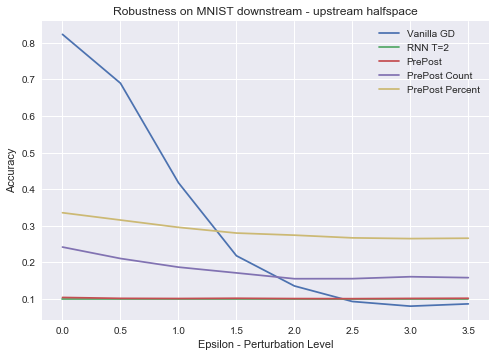

In [15]:
m = [ 'Vanilla GD','RNN T=2', 'PrePost', 'PrePost Count', 'PrePost Percent'  ]
plot_robustness( m, gd_adversary_model='Vanilla GD', save_suffix='nooutgd_blackbox_allsamples',filter_good=False )

Base Test Data Size:  757
Model,EPS,Acc Vanilla GD 0.0 1.0
Model,EPS,Acc PrePost Count 0.0 0.8
Model,EPS,Acc PrePost Percent 0.0 0.8
Model,EPS,Acc Vanilla GD 0.5 0.8818580501263942
Model,EPS,Acc PrePost Count 0.5 0.6366274239112373
Model,EPS,Acc PrePost Percent 0.5 0.7732119346185382
Model,EPS,Acc Vanilla GD 1.0 0.5831058035445797
Model,EPS,Acc PrePost Count 1.0 0.5635820290458476
Model,EPS,Acc PrePost Percent 1.0 0.7306091666255795
Model,EPS,Acc Vanilla GD 1.5 0.32230152209107976
Model,EPS,Acc PrePost Count 1.5 0.4774232721044088
Model,EPS,Acc PrePost Percent 1.5 0.7079263426811074
Model,EPS,Acc Vanilla GD 2.0 0.14140544769278587
Model,EPS,Acc PrePost Count 2.0 0.42445687405613775
Model,EPS,Acc PrePost Percent 2.0 0.6851284748282103
Model,EPS,Acc Vanilla GD 2.5 0.11578554049247713
Model,EPS,Acc PrePost Count 2.5 0.3971030848202302
Model,EPS,Acc PrePost Percent 2.5 0.6817998710777788
Model,EPS,Acc Vanilla GD 3.0 0.09434318205583254
Model,EPS,Acc PrePost Count 3.0 0.40329829059360833
Mo

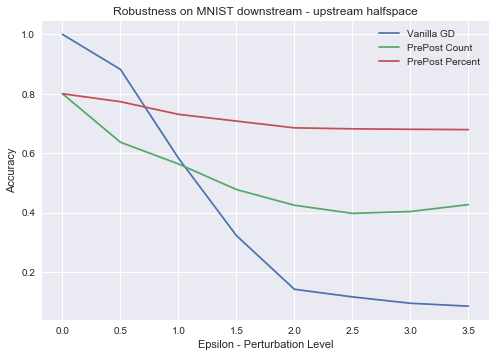

In [20]:
m = [ 'Vanilla GD', 'PrePost Count', 'PrePost Percent'  ]
plot_robustness( m, gd_adversary_model='Vanilla GD', save_suffix='nooutgd_blackbox_modelsagree',filter_good=True )

Base Test Data Size:  3333
Model:  Vanilla GD
Model,EPS,Acc Vanilla GD 0.0 0.7207160714517848
Model,EPS,Acc Vanilla GD 0.5 0.646155573408335
Model,EPS,Acc Vanilla GD 1.0 0.4345109839367554
Model,EPS,Acc Vanilla GD 1.5 0.2373910806384152
Model,EPS,Acc Vanilla GD 2.0 0.14230393743292669
Model,EPS,Acc Vanilla GD 2.5 0.09406498855020103
Model,EPS,Acc Vanilla GD 3.0 0.08093779643540512
Model,EPS,Acc Vanilla GD 3.5 0.0715631765177916
Model:  RNN T=2
Model,EPS,Acc RNN T=2 0.0 0.1
Model,EPS,Acc RNN T=2 0.5 0.1
Model,EPS,Acc RNN T=2 1.0 0.1
Model,EPS,Acc RNN T=2 1.5 0.1
Model,EPS,Acc RNN T=2 2.0 0.1
Model,EPS,Acc RNN T=2 2.5 0.1
Model,EPS,Acc RNN T=2 3.0 0.1
Model,EPS,Acc RNN T=2 3.5 0.1
Model:  PrePost
Model,EPS,Acc PrePost 0.0 0.09949748743718592
Model,EPS,Acc PrePost 0.5 0.09949748743718592
Model,EPS,Acc PrePost 1.0 0.1
Model,EPS,Acc PrePost 1.5 0.1
Model,EPS,Acc PrePost 2.0 0.1
Model,EPS,Acc PrePost 2.5 0.1
Model,EPS,Acc PrePost 3.0 0.1
Model,EPS,Acc PrePost 3.5 0.1
Model:  PrePost Count
Mo

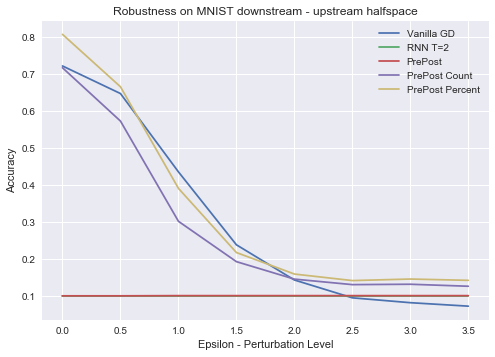

In [24]:
m = [ 'Vanilla GD','RNN T=2', 'PrePost', 'PrePost Count', 'PrePost Percent'  ]
plot_robustness( m, gd_adversary_model='', save_suffix='nooutgd_whitebox_allsamples',filter_good=False )

Base Test Data Size:  1959
Model:  Vanilla GD
Model,EPS,Acc Vanilla GD 0.0 1.0
Model,EPS,Acc Vanilla GD 0.5 0.799825945649642
Model,EPS,Acc Vanilla GD 1.0 0.5523917866136719
Model,EPS,Acc Vanilla GD 1.5 0.2964145620272926
Model,EPS,Acc Vanilla GD 2.0 0.17893017626557237
Model,EPS,Acc Vanilla GD 2.5 0.12145948457973425
Model,EPS,Acc Vanilla GD 3.0 0.09413969435112117
Model,EPS,Acc Vanilla GD 3.5 0.08692477093259118
Model:  PrePost Count
Model,EPS,Acc PrePost Count 0.0 0.9966832504145936
Model,EPS,Acc PrePost Count 0.5 0.8060082833367433
Model,EPS,Acc PrePost Count 1.0 0.35177619443873
Model,EPS,Acc PrePost Count 1.5 0.2093747446881013
Model,EPS,Acc PrePost Count 2.0 0.1661703822538876
Model,EPS,Acc PrePost Count 2.5 0.14719148181721303
Model,EPS,Acc PrePost Count 3.0 0.14125859922466008
Model,EPS,Acc PrePost Count 3.5 0.14104618342698252
Model:  PrePost Percent
Model,EPS,Acc PrePost Percent 0.0 0.9988944168048646
Model,EPS,Acc PrePost Percent 0.5 0.8681944484667076
Model,EPS,Acc PrePost

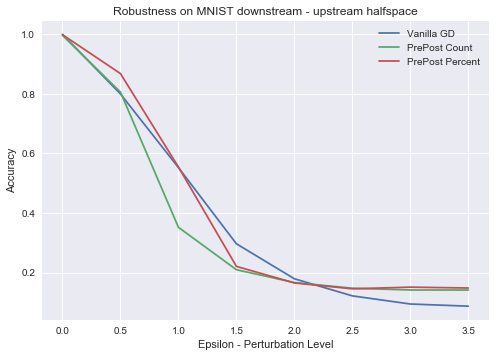

In [25]:
m = [ 'Vanilla GD','PrePost Count', 'PrePost Percent' ]
plot_robustness( m, gd_adversary_model='', save_suffix='nooutgd_blackbox_modelsagree',filter_good=True )

Base Test Data Size:  3927
Model:  Vanilla GD
Model,EPS,Acc Vanilla GD 0.0 1.0
Model,EPS,Acc Vanilla GD 0.5 0.8831102125401016
Model,EPS,Acc Vanilla GD 1.0 0.4878384252500544
Model,EPS,Acc Vanilla GD 1.5 0.34785200369854014
Model,EPS,Acc Vanilla GD 2.0 0.35649486224931726
Model,EPS,Acc Vanilla GD 2.5 0.3621942362655868
Model,EPS,Acc Vanilla GD 3.0 0.36774252801657226
Model,EPS,Acc Vanilla GD 3.5 0.3667536912296372
Model:  PrePost Count
Model,EPS,Acc PrePost Count 0.0 0.9948132780082988
Model,EPS,Acc PrePost Count 0.5 0.7459257955726061
Model,EPS,Acc PrePost Count 1.0 0.3012386400894685
Model,EPS,Acc PrePost Count 1.5 0.07618150764446746
Model,EPS,Acc PrePost Count 2.0 0.03378513966791749
Model,EPS,Acc PrePost Count 2.5 0.026856841584958387
Model,EPS,Acc PrePost Count 3.0 0.03460761010828198
Model,EPS,Acc PrePost Count 3.5 0.026567577557181338
Model:  PrePost Percent
Model,EPS,Acc PrePost Percent 0.0 0.9942946058091287
Model,EPS,Acc PrePost Percent 0.5 0.8433451575599389
Model,EPS,Acc P

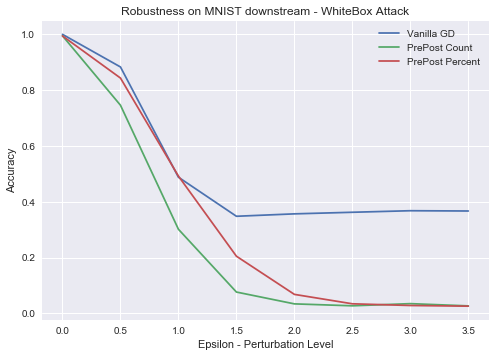

In [8]:
m = [ 'Vanilla GD','PrePost Count', 'PrePost Percent' ]
plot_robustness( m, gd_adversary_model='', save_suffix='outgd_whitebox_modelsagree_w100',filter_good=True )

Base Test Data Size:  3927
Model,EPS,Acc Vanilla GD 0.0 1.0
Model,EPS,Acc PrePost Count 0.0 0.9948132780082988
Model,EPS,Acc PrePost Percent 0.0 0.9942946058091287
Model,EPS,Acc Vanilla GD 0.5 0.8845483629640194
Model,EPS,Acc PrePost Count 0.5 0.9516621604058167
Model,EPS,Acc PrePost Percent 0.5 0.9636235229979011
Model,EPS,Acc Vanilla GD 1.0 0.4878196922625829
Model,EPS,Acc PrePost Count 1.0 0.8999867772351611
Model,EPS,Acc PrePost Percent 1.0 0.9379322614302397
Model,EPS,Acc Vanilla GD 1.5 0.3369876256516783
Model,EPS,Acc PrePost Count 1.5 0.8762018090123438
Model,EPS,Acc PrePost Percent 1.5 0.9249394918820505
Model,EPS,Acc Vanilla GD 2.0 0.36827133293637193
Model,EPS,Acc PrePost Count 2.0 0.8675809387738098
Model,EPS,Acc PrePost Percent 2.0 0.9257658946020003
Model,EPS,Acc Vanilla GD 2.5 0.36828715608099166
Model,EPS,Acc PrePost Count 2.5 0.8694561370987696
Model,EPS,Acc PrePost Percent 2.5 0.9249981421801531
Model,EPS,Acc Vanilla GD 3.0 0.3689410025807498
Model,EPS,Acc PrePost Coun

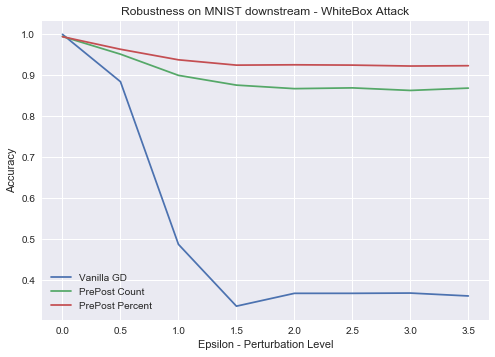

In [7]:
m = [ 'Vanilla GD','PrePost Count', 'PrePost Percent' ]
plot_robustness( m, gd_adversary_model='Vanilla GD', save_suffix='outgd_blackbox_modelsagree_w100',filter_good=True )

In [9]:
#Debugging Space

#1 , 0 rule weight inits
#m_pp = trained_models['PrePost']
#m_pp.hidden_layer_rules[1].get_rule()

#m_pp_randu = trained_models['PrePost']
#m_pp_randu.hidden_layer_rules[1].get_rule()

#m_pp_randu.hidden_weights

#m_pppct_randu = trained_models['PrePost Percent']
#m_pppct_randu.hidden_layer_rules[1].get_rule()
#m_pppct_randu.hidden_weights
#print(m_pppct_randu.output_weights)

#m_pppct_randu_nogd = trained_models['PrePost Percent']
#m_pppct_randu_nogd.hidden_layer_rules[1].get_rule()
#print(m_pppct_randu_nogd.output_rule.get_rule())
#m_pppct_randu_nogd.hidden_weights
#print(m_pppct_randu_nogd.output_weights)

# m_pppct_randn_nogd = trained_models['PrePost Percent']
# m_pppct_randn_nogd.hidden_layer_rules[1].get_rule()
# print(m_pppct_randn_nogd.output_rule.get_rule())
# print(m_pppct_randn_nogd.output_weights)

#m_pppct_const_nogd = trained_models['PrePost Percent']
#m_pppct_const_nogd.hidden_layer_rules[1].get_rule()
#print(m_pppct_const_nogd.output_rule.get_rule())
#print(m_pppct_const_nogd.output_weights)
#m_pppct_const_nogd.hidden_weights


